# preprocess the dataframe that stores wearable and cosmed data
## window data
## prepare them for training and testing later

In [1]:
import numpy as np
import argparse
from numpy import linalg as LA

import os
from os.path import expanduser
home = expanduser("~")

import math
import json

import collections

import pandas as pd
from sklearn.linear_model import LinearRegression

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

import mat73

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from segmentation import *
# from stage1_patch import *
# from TimeStampReader import *
# from Subject import *
# from PatchParser import *
from preprocessing import *
from ECG_module import *
from PPG_module import *
from evaluate import *
from stage1_cosmed import *
from stage3_preprocess import *
from dataIO import *
from resp_module import *

from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
# plot_surrogate_resp

In [3]:
parser = argparse.ArgumentParser(description='activity_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='112')

# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder',  '/mchan_Data/knee_dataset/', 
                          '--output_folder', '../../data/stage3_PatchKnee/',
                          '--subject_id',  '106',
                         ])
# args = parser.parse_args()

print(args)

Namespace(input_folder='/mchan_Data/knee_dataset/', output_folder='../../data/stage3_PatchKnee/', subject_id='106')


# set up using args

In [4]:
subject_id = args.subject_id

inputdir = args.input_folder
inputdir = home + inputdir


outputdir = args.output_folder
outputdir = outputdir+subject_id+'/'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
# training_params_file = args.training_params_file

# with open(training_params_file) as json_file:
#     training_params_list = json.load(json_file)
    
# training_params = training_params_list[0]

In [5]:
# os.listdir(inputdir)

In [6]:
for folder in os.listdir(inputdir):
    if 'Subject' not in folder:
        continue

    filename = folder.split('- ')[-1]+'.mat'

    if 'Output Data' not in os.listdir(inputdir + folder):
        print('\t', 'no Output Data folder for', filename.split('.mat')[0])
        continue


    if str(subject_id) not in filename:
        continue

    print('\tworking on {}'.format(folder.split('- ')[-1]))

    if filename in os.listdir(inputdir+folder+'/Output Data'):
        print('\t', 'got it!')
        print('\t extracting data for', filename)

        mat_dir = home+'/mchan_Data/knee_dataset/{}/Output Data/{}'.format(folder, filename)

        mat = mat73.loadmat(mat_dir)

    else:
        print('no subject .mat')


	working on Subject106
	 got it!
	 extracting data for Subject106.mat


In [7]:
patch_column_names = ['HR_cosmed', 'RR_cosmed', 'VT_cosmed', 'VE_cosmed', 'FeO2_cosmed',
       'FeCO2_cosmed', 'FiO2_cosmed', 'FiCO2_cosmed', 'VO2_cosmed',
       'VCO2_cosmed', 'EE_cosmed', 'SPO2_cosmed', 'GpsAlt_cosmed',
       'AmbTemp_cosmed', 'Battery_cosmed', 'K5_R_cosmed', 'time',
       'Marker_cosmed', 'task', 'Sampled_cosmed', 'ECG', 'accelX', 'accelY',
       'accelZ', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2',
       'ppg_ir_2', 'temp_skin', 'pres', 'OUES_cosmed']

# show all signals

(-10, 20)

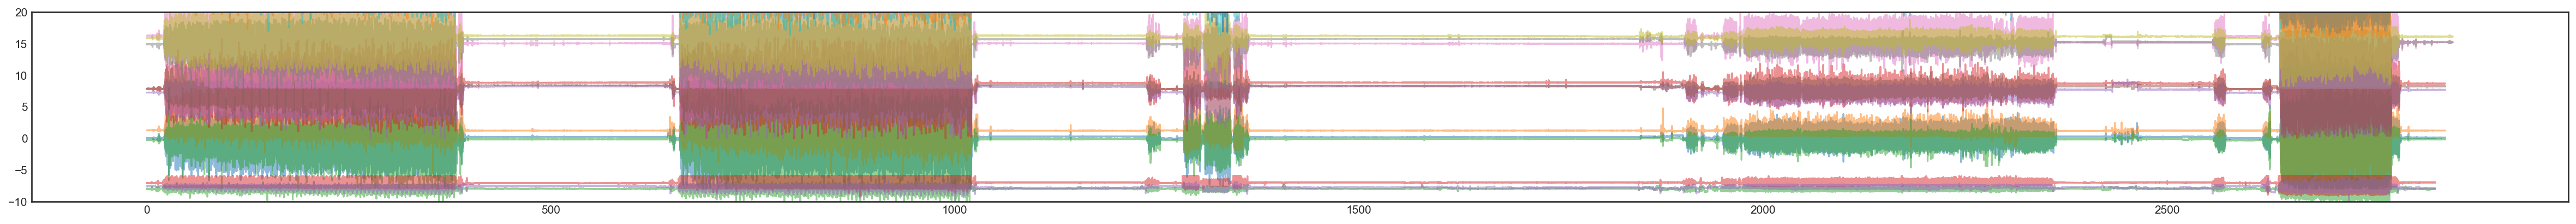

In [8]:
fig, ax = plt.subplots(1,1, figsize=(40,3), dpi=150)
j = 0
for side in ['Left', 'Right']:
    for i_acc in [0, 1]:

        if side not in mat:
            print('{} not in mat'.format(side))
            continue
        t_knee = mat[side]['time_acc{}'.format(i_acc)]
        t_knee = t_knee-t_knee.min()
        acc_knee =  mat[side]['acc{}'.format(i_acc)]
        
        
        ax.plot(t_knee, acc_knee + j*8, alpha=0.5)
        j += 1
        
        
        
        
df = pd.DataFrame(data = mat['Patch'], 
                  columns = patch_column_names)

t_patch = df['time'].values

acc_patch = df[['accelX', 'accelY', 'accelZ']].values
t_patch = t_patch-t_patch.min()
ax.plot(t_patch, acc_patch-8, alpha=0.5)

        
# mask = df['task']==6

# ax.plot(t_patch[mask], acc_patch[mask]-8)


# ax.set_xlim(20,50)
ax.set_ylim(-10,20)
# -1000

# check the start time of each knee signal
## they always have 0 and 1, acc and gyr
## sometimes there is only Left or Right 

In [9]:
t_arr = []
for side in ['Left', 'Right']:
    for i_sig in [0, 1]:
        for modality in ['acc', 'gyr']:
        
            if side not in mat:
                print('{} not in mat'.format(side))
                continue
            t = mat[side]['time_{}{}'.format(modality, i_sig)]
            sig_knee =  mat[side]['{}{}'.format(modality, i_sig)]

            t_arr.append(t.min())
            print(side, i_sig, modality, t.min(), t.max(), t.shape, sig_knee.shape)
            
t_knee_min = min(t_arr)

Left 0 acc 253.075439453125 3097.36865234375 (732923,) (732923, 3)
Left 0 gyr 253.075439453125 3097.364990234375 (302041,) (302041, 3)
Left 1 acc 253.075439453125 3097.36865234375 (324341,) (324341, 3)
Left 1 gyr 253.075439453125 3097.364990234375 (302886,) (302886, 3)
Right 0 acc 253.979736328125 3107.619140625 (732923,) (732923, 3)
Right 0 gyr 253.983642578125 3107.619140625 (303356,) (303356, 3)
Right 1 acc 253.979736328125 3107.619140625 (326911,) (326911, 3)
Right 1 gyr 253.979736328125 3107.623046875 (304266,) (304266, 3)


# combine patch and knee data without alignment

In [10]:
df_patch = pd.DataFrame(data = mat['Patch'], 
                  columns = patch_column_names)

df_patch = df_patch[['time', 'accelX', 'accelY', 'accelZ', 'task']].rename(columns={'time': 't_sync','accelX': 'acc_X_patch','accelY': 'acc_Y_patch','accelZ': 'acc_Z_patch'})
df_patch['t_sync'] = df_patch['t_sync'] - df_patch['t_sync'].min() + t_knee_min

# find delay between brace and patch

In [11]:

def lag_finder(t1, y1, t2, y2, Fs, debug=True, fig_name=None, show_plot=False, outputdir=None):
    
    # get the length of these signals, find the longer one (store the size in n)
    n1 = len(y1)
    n2 = len(y2)
    n = max(n1, n2)

    # create two signals with size of n, fill in y1 and y2, if y1 or y2 not long enough, the signals will fill in 0's
    y1_filled = np.zeros(n)
    y2_filled = np.zeros(n)
    y1_filled[:n1] = y1
    y2_filled[:n2] = y2
    
    
    y1_filled = get_padded_filt(y1_filled, filter_padded=1, lowcutoff=5, highcutoff=30, Fs=Fs)
    y2_filled = get_padded_filt(y2_filled, filter_padded=1, lowcutoff=5, highcutoff=30, Fs=Fs)


    # compute cross correlation 
    corr = signal.correlate(y2_filled, y1_filled, mode='same')
    # corr = signal.correlate(y2_filled, y1_filled, mode='same') / np.sqrt(signal.correlate(y1_filled, y1_filled, mode='same')[int(n1/2)] * signal.correlate(y2_filled, y2_filled, mode='same')[int(n2/2)])
    # create the delay array
    delay_arr = np.linspace(-0.5*n/Fs, 0.5*n/Fs, n)
    # find the delay that maximizes the xcorr
    t_delay = delay_arr[np.argmax(np.abs(corr))]

    # print('t1 starts at {}, t2 starts at {}'.format(t1_start, t2_start_temp))
    

    
    if debug:
        print('t_delay is {}s'.format(t_delay))
        print('change t2 to t2 - t_delay')

        fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(1, 1, 1)
        fontsize = 8

        ax.plot(delay_arr, corr)
        ax.set_title('Lag: ' + str(np.round(t_delay, 3)) + ' s', fontsize=fontsize)
        ax.set_xlabel('Lag', fontsize=fontsize)
        ax.set_ylabel('Correlation coeff', fontsize=fontsize)

        # fig_name = 'xcorr'

        fig.tight_layout()


        if fig_name is None:
            fig_name = 'xcorr'

        if outputdir is not None:
            if not os.path.exists(outputdir):
                os.makedirs(outputdir)
            fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

        if show_plot == False:
            plt.close(fig)
            pyplot.close(fig)
            plt.close('all')


    return t_delay

In [12]:
t_delay_dict = {}
t_sync = df_patch['t_sync'].values


for side in ['Left', 'Right']:   
    if side not in mat:
        print('{} not in mat'.format(side))
        continue

    modality = 'acc'
    i_sig = 0

    t_knee = mat[side]['time_{}{}'.format(modality, i_sig)]
    sig_knee =  mat[side]['{}{}'.format(modality, i_sig)]
    sig_knee = np.interp(t_sync, t_knee, sig_knee[:,1])

    t_delay_dict[side] = lag_finder(t_sync, df_patch['acc_Z_patch'].values, t_sync, sig_knee, Fs=250, debug=True, fig_name='xcorr_'+side, outputdir=outputdir)

t_delay is 2.768003910035304s
change t2 to t2 - t_delay
t_delay is 2.4280034297564725s
change t2 to t2 - t_delay


In [13]:
t_sync = df_patch['t_sync'].values

df_patch_knee = []

for side in ['Left', 'Right']:   
    
    for i_sig in [0, 1]:
        for modality in ['acc', 'gyr']:
        
            if side not in mat:
                print('{} not in mat'.format(side))
                continue

            t_knee = mat[side]['time_{}{}'.format(modality, i_sig)] - t_delay_dict[side]
            sig_knee =  mat[side]['{}{}'.format(modality, i_sig)]

            sig_knee = [np.interp(t_sync, t_knee, sig_knee[:,i]) for i in range(sig_knee.shape[1])]
            sig_knee = np.asarray(sig_knee).T
            
            knee_columns = []
            for axis in ['X','Y','Z']:
                knee_columns.append('{}_{}{}_{}_knee'.format(side, modality, i_sig, axis))
            
        
            df = pd.DataFrame(sig_knee, columns=knee_columns)

            df_patch_knee.append(df)
            # print(side, i_sig, modality, t.min(), t.max(), t.shape, sig_knee.shape)
            
            


            
            
df_patch_knee = pd.concat(df_patch_knee,axis=1)
print(df_patch_knee.columns)

df_patch_knee = pd.concat([df_patch, df_patch_knee],axis=1)

Index(['Left_acc0_X_knee', 'Left_acc0_Y_knee', 'Left_acc0_Z_knee',
       'Left_gyr0_X_knee', 'Left_gyr0_Y_knee', 'Left_gyr0_Z_knee',
       'Left_acc1_X_knee', 'Left_acc1_Y_knee', 'Left_acc1_Z_knee',
       'Left_gyr1_X_knee', 'Left_gyr1_Y_knee', 'Left_gyr1_Z_knee',
       'Right_acc0_X_knee', 'Right_acc0_Y_knee', 'Right_acc0_Z_knee',
       'Right_gyr0_X_knee', 'Right_gyr0_Y_knee', 'Right_gyr0_Z_knee',
       'Right_acc1_X_knee', 'Right_acc1_Y_knee', 'Right_acc1_Z_knee',
       'Right_gyr1_X_knee', 'Right_gyr1_Y_knee', 'Right_gyr1_Z_knee'],
      dtype='object')


In [14]:
df_patch_knee

,t_sync,acc_X_patch,acc_Y_patch,acc_Z_patch,task,Left_acc0_X_knee,Left_acc0_Y_knee,Left_acc0_Z_knee,Left_gyr0_X_knee,Left_gyr0_Y_knee,Left_gyr0_Z_knee,Left_acc1_X_knee,Left_acc1_Y_knee,Left_acc1_Z_knee,Left_gyr1_X_knee,Left_gyr1_Y_knee,Left_gyr1_Z_knee,Right_acc0_X_knee,Right_acc0_Y_knee,Right_acc0_Z_knee,Right_gyr0_X_knee,Right_gyr0_Y_knee,Right_gyr0_Z_knee,Right_acc1_X_knee,Right_acc1_Y_knee,Right_acc1_Z_knee,Right_gyr1_X_knee,Right_gyr1_Y_knee,Right_gyr1_Z_knee
0,253.075439,-0.059202,0.933878,0.387670,NaN,0.042095,1.278570,-0.231605,-0.430904,-11.790507,-0.875411,-0.131332,-0.750720,-0.154098,1.037000,14.640000,4.575000,0.258060,-1.091404,-0.137364,-2.720958,23.293986,5.426329,0.090187,1.110440,-0.234600,-0.340324,-8.697324,-3.555662
1,253.079439,-0.064109,0.931843,0.389013,NaN,0.040109,1.278570,-0.234600,-0.181048,-12.134059,-0.969107,-0.129997,-0.750720,-0.155433,1.076345,14.765904,4.527786,0.257452,-1.094192,-0.140152,-2.533566,23.231522,5.405507,0.092189,1.110440,-0.234600,-0.271827,-8.614610,-3.533261
2,253.083439,-0.068203,0.929400,0.388632,NaN,0.041907,1.277467,-0.234600,0.028670,-12.377266,-1.054202,-0.128479,-0.750720,-0.156951,1.232505,15.265616,4.340394,0.253449,-1.091591,-0.136850,-2.346174,23.169058,5.384686,0.093840,1.110791,-0.233548,-0.053203,-8.302290,-3.502029
3,253.087439,-0.072594,0.926406,0.388084,NaN,0.040296,1.274660,-0.235796,0.132777,-12.356445,-1.116666,-0.126477,-0.750720,-0.158953,1.373110,15.703108,4.165446,0.249445,-1.094800,-0.135260,-2.151178,23.048566,5.348791,0.093840,1.112793,-0.227542,0.160010,-7.980203,-3.489670
4,253.091439,-0.074498,0.923743,0.389142,NaN,0.040429,1.273370,-0.237220,0.236883,-12.335623,-1.179130,-0.125120,-0.749860,-0.159880,1.477217,15.994607,4.019697,0.245382,-1.094800,-0.129030,-1.925502,22.693931,5.252072,0.093840,1.114350,-0.223173,0.351389,-7.618709,-3.553463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707918,3084.747439,-0.038358,1.001540,0.089842,4.0,0.136179,1.235560,-0.149251,-0.050316,-0.366000,0.369561,0.684250,-0.313135,0.238510,0.636154,0.249231,0.193461,-0.782000,-0.778090,0.121210,-0.002642,0.183000,0.421716,-0.074290,1.106530,-0.199410,-0.122000,0.045148,-0.366000
707919,3084.751439,-0.037496,0.999328,0.091362,4.0,0.133517,1.232227,-0.151913,-0.087001,-0.313997,0.418003,0.685361,-0.313911,0.239621,0.505995,0.174663,0.148332,-0.778335,-0.778090,0.124875,-0.019060,0.183000,0.407940,-0.074290,1.106530,-0.200632,-0.064820,0.061000,-0.385060
707920,3084.755439,-0.036952,1.000947,0.089042,4.0,0.136367,1.235077,-0.152490,-0.118233,-0.251533,0.480467,0.686696,-0.315246,0.240956,0.381067,0.091378,0.106689,-0.778090,-0.778090,0.128879,-0.039881,0.183000,0.387119,-0.074290,1.106530,-0.201966,-0.002356,0.061000,-0.405881
707921,3084.759439,-0.033038,1.006190,0.085711,4.0,0.136850,1.235560,-0.152490,-0.176931,-0.280620,0.469690,0.688030,-0.316580,0.242290,0.256139,0.008093,0.065046,-0.778090,-0.774237,0.125177,-0.060703,0.183000,0.366297,-0.074290,1.106530,-0.203301,0.060108,0.061000,-0.426703


In [15]:
# df_patch_knee.columns

In [16]:
def plot_regression(df_patch_knee, scale=None, fig_name=None, show_plot=False, outputdir=None):

    fig, axes = plt.subplots(df_patch_knee.shape[1]-2,1, figsize=(30,df_patch_knee.shape[1]*1.8), dpi=150)
    def get_cmap(n, name='hsv'):
        '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
        RGB color; the keyword argument name must be a standard mpl colormap name.'''
        return plt.cm.get_cmap(name, n)

    cmap = get_cmap(len(df_patch_knee.columns))


    i = 0

    t_sig = df_patch_knee['t_sync'].values
    mask = df_patch_knee['task']==6
    

    for sig_name in df_patch_knee.columns:
        if sig_name=='t_sync':
            continue
        if sig_name=='task':
            continue
        # print(sig_name)

        ax = axes[i]

        sig = df_patch_knee[sig_name].values
        ax.plot(t_sig[mask], sig[mask], alpha=0.3, c=cmap(i))
        ax.set_ylabel(sig_name)
        i += 1


    ax.set_xlabel('time (s)')

    for ax in axes:
        ax_no_top_right(ax)
        
        if scale=='ZoomIn':
            ax.set_xlim(t_sig[mask].min(),t_sig[mask].min()+50)
        else:
            ax.set_xlim(t_sig[mask].min(),t_sig[mask].max())

    fig.tight_layout()


    if fig_name is None:
        fig_name = 'IMUsignals'

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')


In [17]:
plot_regression(df_patch_knee, fig_name='IMUsignals', show_plot=False, outputdir=outputdir)


In [18]:
plot_regression(df_patch_knee, scale='ZoomIn', fig_name='IMUsignals(50s)', show_plot=False, outputdir=outputdir)


In [19]:
df_demographics = pd.read_excel('demographics.xlsx', index_col=0)  
df_demographics

,Age,Height(cm),Weight(Kg),"Gender(0=Male,1=Female)",Fitzpatrick,Dominant leg,6MWT distance (m),6MWT-R distance (m),which first,Indoor temperature (F),Indoor Humidity (%),Note
Subject_ID,,,,,,,,,,,,
102,30,177.80,75.00,1,2,R,559.180,539.630,6MWT,72.3,61,subject talked a lot. COSMED data might be cor...
106,28,178.00,76.00,1,1,R,806.583,750.360,6MWT-R,80.9,29,face mask too small
107,27,194.00,90.72,1,1,L,585.505,567.140,6MWT-R,75.9,33,did second cough and speech after outdoor walk...
108,24,180.34,70.76,1,2,R,480.480,411.790,6MWT,66.2,35,"timestamper guy changed from MC to MS, minimal..."
109,21,160.02,52.16,2,2,R,578.900,537.029,6MWT-R,66.2,37,"occasionally spoke, overall minimal motion, de..."
110,22,182.88,93.00,1,3,R,578.760,574.140,6MWT,65.0,36,"occasionally spoke, overall minimal motion"
111,28,153.00,45.00,2,1,R,611.520,573.940,6MWT-R,68.0,46,"overall a good subject, start walking near the..."
113,24,198.12,104.33,1,1,R,565.820,459.240,6MWT-R,68.0,49,"good subject, ran fast"
114,27,175.00,60.00,1,1,R,605.200,589.650,6MWT,68.9,57,"minimal motion, good subject"


In [20]:
# df_demographics.shape

Index(['t_sync', 'acc_X_patch', 'acc_Y_patch', 'acc_Z_patch', 'task',
       'Left_acc0_X_knee', 'Left_acc0_Y_knee', 'Left_acc0_Z_knee',
       'Left_gyr0_X_knee', 'Left_gyr0_Y_knee', 'Left_gyr0_Z_knee',
       'Left_acc1_X_knee', 'Left_acc1_Y_knee', 'Left_acc1_Z_knee',
       'Left_gyr1_X_knee', 'Left_gyr1_Y_knee', 'Left_gyr1_Z_knee',
       'Right_acc0_X_knee', 'Right_acc0_Y_knee', 'Right_acc0_Z_knee',
       'Right_gyr0_X_knee', 'Right_gyr0_Y_knee', 'Right_gyr0_Z_knee',
       'Right_acc1_X_knee', 'Right_acc1_Y_knee', 'Right_acc1_Z_knee',
       'Right_gyr1_X_knee', 'Right_gyr1_Y_knee', 'Right_gyr1_Z_knee'],
      dtype='object')

# split 2 6MWT, choose the regular one

In [23]:
mask = df_patch_knee['task']==6
i_split = np.where(np.diff(df_patch_knee[mask]['t_sync'])>0.1)[0][0]


df_first6MWT = df_patch_knee[mask][:i_split+1]
df_second6MWT = df_patch_knee[mask][i_split+1:]

df_first6MWT = df_first6MWT.reset_index(drop=True)
df_second6MWT = df_second6MWT.reset_index(drop=True)

print(df_first6MWT['t_sync'].max()-df_first6MWT['t_sync'].min())
print(df_second6MWT['t_sync'].max()-df_second6MWT['t_sync'].min())

if df_demographics['which first'][int(subject_id)]=='6MWT':
    print('{} first'.format(df_demographics['which first'][int(subject_id)]))
    df_first6MWT.to_feather(outputdir+'df_6MWT.feather')
    df_second6MWT.to_feather(outputdir+'df_6MWTR.feather')
else:
    print('{} first'.format(df_demographics['which first'][int(subject_id)]))
    
    df_first6MWT.to_feather(outputdir+'df_6MWTR.feather')
    df_second6MWT.to_feather(outputdir+'df_6MWT.feather')


360.1199999999999
361.35199999999986
6MWT-R first


In [27]:
1/np.diff(df_first6MWT['t_sync'].values)

array([250.00000001, 250.00000001, 249.99999998, ..., 250.00000001,
       250.00000001, 250.00000001])

In [25]:
df_first6MWT.columns

Index(['t_sync', 'acc_X_patch', 'acc_Y_patch', 'acc_Z_patch', 'task',
       'Left_acc0_X_knee', 'Left_acc0_Y_knee', 'Left_acc0_Z_knee',
       'Left_gyr0_X_knee', 'Left_gyr0_Y_knee', 'Left_gyr0_Z_knee',
       'Left_acc1_X_knee', 'Left_acc1_Y_knee', 'Left_acc1_Z_knee',
       'Left_gyr1_X_knee', 'Left_gyr1_Y_knee', 'Left_gyr1_Z_knee',
       'Right_acc0_X_knee', 'Right_acc0_Y_knee', 'Right_acc0_Z_knee',
       'Right_gyr0_X_knee', 'Right_gyr0_Y_knee', 'Right_gyr0_Z_knee',
       'Right_acc1_X_knee', 'Right_acc1_Y_knee', 'Right_acc1_Z_knee',
       'Right_gyr1_X_knee', 'Right_gyr1_Y_knee', 'Right_gyr1_Z_knee'],
      dtype='object')

In [22]:
sys.exit()

SystemExit: 

/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:

t_sync = df_patch_knee['t_sync'].values

for knee_name in df_patch_knee.columns:
    if 't_sync' in knee_name:
        continue
    if 'patch' in knee_name:
        continue
    if 'task' in knee_name:
        continue

    # for patch_name in ['acc_X_patch', 'acc_Y_patch', 'acc_Z_patch']:
    for patch_name in ['acc_Y_patch']:
        # for k in range(3):
        t_delay = lag_finder(t_sync, df_patch_knee[patch_name].values, t_sync, df_patch_knee[knee_name].values, Fs=250, debug=False)
        print('{} vs. {}: {:.4f}s'.format(patch_name, knee_name, t_delay))

In [ ]:
df_patch_knee.columns

In [ ]:
mask = df_patch_knee['task']==6
i_split = np.where(np.diff(df_patch_knee[mask]['t_sync'])>0.1)[0][0]


plt.plot(df_patch_knee[mask][:i_split+1]['acc_Z_patch'], 'r')
plt.plot(df_patch_knee[mask][:i_split+1]['Left_acc0_Z_knee'], 'b')


# plt.plot(medfilt(df_patch_knee[mask][:i_split+1]['acc_Y_patch'].values[::50], k=51) , 'r', alpha=0.5)
# plt.plot(medfilt(df_patch_knee[mask][:i_split+1]['Left_acc0_Y_knee'].values[::50], k=51), 'b', alpha=0.5)




# plt.plot(df_patch_knee[mask][i_split+1:])
plt.xlim(5000,7000)

In [ ]:
outputdir

In [ ]:
df_task[list_sungtae_columns].to_feather(outputdir+'df_sync_extracted_{}.feather'.format(subject_id))


In [ ]:
# acc_knee = [np.interp(t_sync, t_knee, acc_knee[:,i]) for i in range(acc_knee.shape[1])]


In [ ]:
# # fig, ax = plt.subplots(1,1, figsize=(20,3), dpi=150)
# # j = 0
# for side in ['Left', 'Right']:
#     for i_acc in [0, 1]:

#         t_knee = mat[side]['time_acc{}'.format(i_acc)]
#         t_knee = t_knee-t_knee.min()
#         acc_knee =  mat[side]['acc{}'.format(i_acc)]
        
#         print(side, i_acc, t_knee.shape, acc_knee.shape)
        
        
        

In [ ]:
np.median(1/np.diff(t_knee))

In [ ]:
side = 'Left'
i_acc = 1

t_knee = mat[side]['time_acc{}'.format(i_acc)]
t_knee = t_knee-t_knee.min()
acc_knee =  mat[side]['acc{}'.format(i_acc)]

acc_knee = [np.interp(t_sync, t_knee, acc_knee[:,i]) for i in range(acc_knee.shape[1])]
acc_knee_Left = np.asarray(acc_knee).T


# side = 'Right'
# i_acc = 1

# t_knee = mat[side]['time_acc{}'.format(i_acc)]
# t_knee = t_knee-t_knee.min()
# acc_knee =  mat[side]['acc{}'.format(i_acc)]

# acc_knee = [np.interp(t_sync, t_knee, acc_knee[:,i]) for i in range(acc_knee.shape[1])]
# acc_knee_Right = np.asarray(acc_knee).T

# acc_knee = acc_knee_Right + acc_knee_Left

acc_knee = acc_knee_Left

In [ ]:
# acc_knee_Left

In [ ]:
t_patch

In [ ]:
mask = (t_patch>=0) & (t_patch<=500)

t_sync[mask].shape, acc_patch[mask,0].shape, t_sync[mask].shape, acc_knee[mask,0].shape

In [ ]:
plt.plot(sig_knee[150000:160000,0],'b')
plt.plot(sig_knee[150000:160000,1],'r')
plt.plot(sig_knee[150000:160000,2],'g')

fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)

# ax.plot(sig_knee[50000:53000,0],'b') # HF
# ax.plot(sig_knee[50000:53000,1],'r') # forward backward
# ax.plot(sig_knee[50000:53000,2],'g') # LR

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,3), dpi=150)
j = 0



ax.plot(t_sync-t_delay, get_padded_filt(acc_knee[:,j], filter_padded=1, lowcutoff=1, highcutoff=15, Fs=250))
ax.plot(t_sync, get_padded_filt(acc_patch[:,j], filter_padded=1, lowcutoff=1, highcutoff=15, Fs=250)*10, 'r')


# ax.plot(t_sync-t_delay, acc_knee[:,j])
# ax.plot(t_sync, acc_patch[:,j]*10, 'r')



ax.set_xlim(780,820)
# ax.set_ylim(-5,10)
# -1000

In [ ]:
t_knee.shape

In [ ]:
t_patch.shape

In [ ]:
acc_knee.shape

In [ ]:
df['task'].unique()

In [ ]:
plt.plot(df['time'], df['task'])

In [ ]:
# import scipy.io
import mat73
# data_dict = mat73.loadmat('data.mat')

mat_dir = home+'/mchan_Data/knee_dataset/20220208 - Subject116/Output Data/Subject116.mat'

mat = mat73.loadmat(mat_dir)

In [ ]:
mat

In [ ]:
# df_sync = pd.read_csv(home + '/mchan_Data/knee_dataset/20220208 - Subject116/Output Data/df_sync.csv')

In [ ]:
# df_sync

In [ ]:

# creating the dataframe

In [ ]:
# df

In [ ]:
t_patch = df['time'].values

acc_patch = df[['accelX', 'accelY', 'accelZ']].values


plt.plot(t_patch, acc_patch)

In [ ]:
acc0 = mat['Left']['acc0']
t_acc0 = mat['Left']['time_acc0']

plt.plot(t_acc0, acc0)

In [ ]:
acc0 = mat['Left']['acc0']
t_acc0 = mat['Left']['time_acc0']

plt.plot(t_acc0, acc0)

In [ ]:
sys.exit()

In [ ]:
# feature_all